In [ ]:
!pip install --upgrade matplotlib
!git clone https://github.com/marcustriplett/circuitmap
!pip install ./circuitmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'circuitmap' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./circuitmap
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for circuitmap: filename=circuitmap-0.2.0-py3-none-any.whl size=32119 sha256=73ecf5b24ca16d38adbec16fafad73afe09d835d6dd4e55c215e7aa8a87dfa85
  Stored in directory: /tmp/pip-ephem-wheel-cache-ecygd_a3/wheels/b7/8f/23/ef76c798b6604236671bdc4a2ac374b979e2564fa684eb5521
Successfully bu

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import circuitmap as cm
from circuitmap import NeuralDemixer
from circuitmap.simulation import simulate_continuous_experiment
from circuitmap.viz import plot_checkerboard
from sklearn.metrics import r2_score

In [ ]:
fontsize=14

In [ ]:
# Load pretrained NWD network
# Placing network on CPU prevents GPU memory conflicts with JAX

demix = NeuralDemixer(path='circuitmap/demixers/nwd_ie_ChroME2f.ckpt', device='cpu') # for inhibitory PSCs
# demix = NeuralDemixer(path='circuitmap/demixers/nwd_ee_ChroME1.ckpt', device='cpu') # for excitatory PSCs

In [ ]:
# Setup simulation parameters
N = 200                               # number of presynaptic candidate neurons
stim_freq = 30                        # in Hz
sampling_freq = 20000                 # 20 kHz
expt_len = 2 * 60 * sampling_freq     # 2 minute simulation
H = 10                                # number of simultaneously targeted neurons
nreps = 1                             # holograms are not repeated
spont_rate = 2                        # in Hz
connection_prob = 0.1                 # 10% connection probability
powers = [45, 55, 65]                 # laser powers used in experiment (mW)

In [ ]:
# Run simulation
sim = simulate_continuous_experiment(N=N, stim_freq=stim_freq, expt_len=expt_len, H=H, nreps=nreps, spont_rate=spont_rate,
                                     connection_prob=connection_prob, powers=powers, ground_truth_eval_batch_size=100) # reduce batch size in case of memory issues

Creating simulation with specifications:
Population size 200
Hologram targets 10
Response window (frames) 900
Stimulus frequency (Hz) 30
Experiment duration (s) 120.00
Sampling frequency (KHz) 20.0
Hologram repetitions 1
Connection density 0.1
Spontaneous PSC rate (Hz) 2
Powers [45, 55, 65]


In [ ]:
# Extract relevant data
psc = sim['obs_responses']
stim_matrix = sim['stim_matrix']

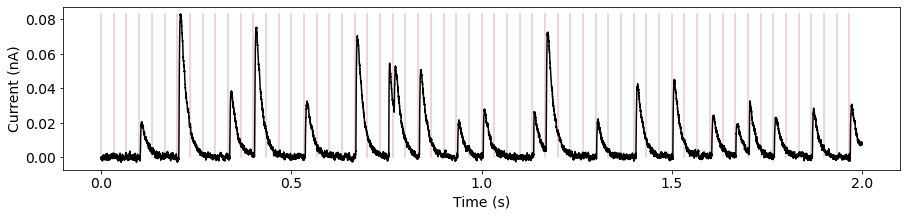

In [ ]:
# Plot first 2 seconds of experiment

plot_len = 2 * sampling_freq
xticks = np.arange(0, plot_len+1, sampling_freq/2)
xticklabels = np.arange(0, 2.1, 0.5)
ylim = [0, np.max(sim['pscs'][:plot_len])]
plt.figure(figsize=(15, 3))
plt.plot(sim['pscs'][:plot_len], color='k')
isi = sampling_freq/stim_freq
for pi in range(int(plot_len/isi)):
  plt.plot([isi * pi, isi * pi], ylim, color='firebrick', zorder=-1, alpha=0.25)
plt.ylabel('Current (nA)', fontsize=fontsize)
plt.xlabel('Time (s)', fontsize=fontsize)
plt.xticks(xticks)
plt.gca().set_xticklabels(xticklabels, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

In [ ]:
# Demix traces
psc_dem = demix(psc)

Demixing PSC traces... complete (elapsed time 6.44s, device=cpu).


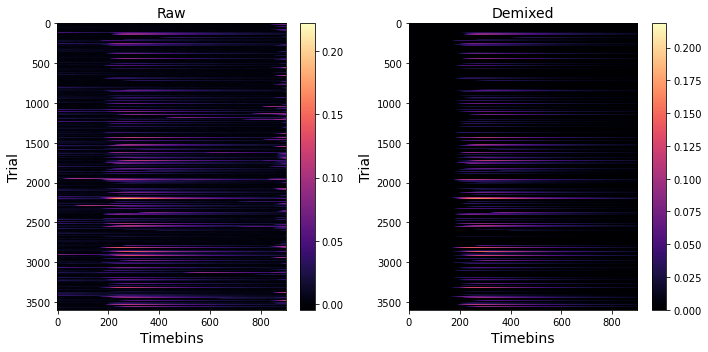

In [ ]:
# Visualise overall removal of confounding currents

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(psc, aspect='auto', interpolation='nearest', cmap='magma')
plt.xlabel('Timebins', fontsize=fontsize)
plt.ylabel('Trial', fontsize=fontsize)
plt.title('Raw', fontsize=fontsize)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(psc_dem, aspect='auto', interpolation='nearest', cmap='magma')
plt.xlabel('Timebins', fontsize=fontsize)
plt.ylabel('Trial', fontsize=fontsize)
plt.colorbar()
plt.title('Demixed', fontsize=fontsize)
plt.tight_layout()

plt.show()

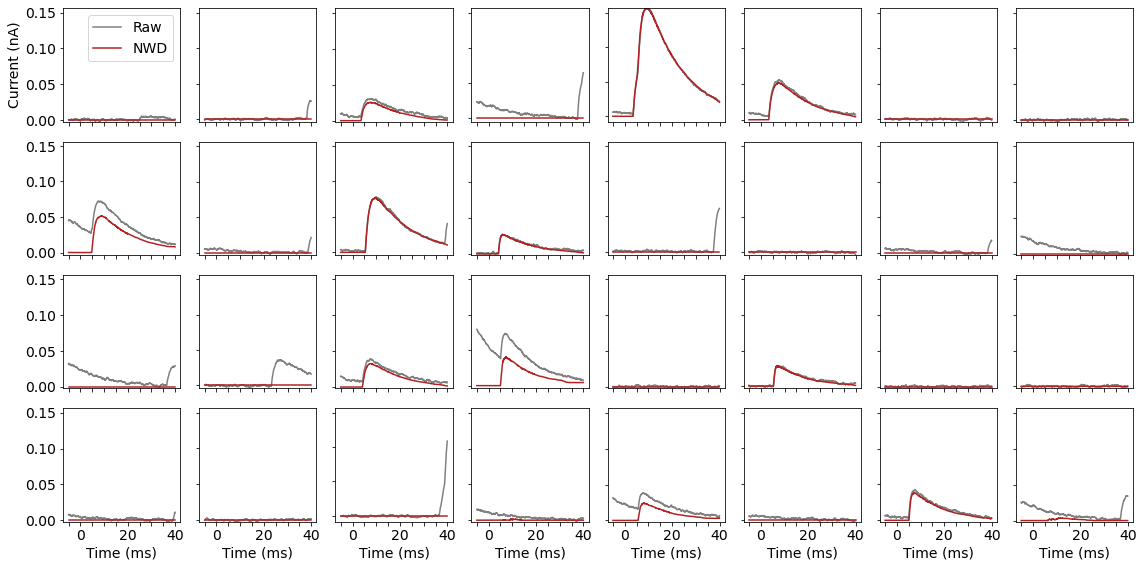

In [ ]:
K = stim_matrix.shape[1]
n_examples = 32
example_trials = np.random.choice(K, n_examples, replace=False)

ms = sampling_freq/1000
xs = np.arange(-5*ms, 40*ms)
xticks = np.arange(-5*ms, 41*ms, 5*ms)
xticklabels = ['' for _ in range(10)]
xticklabels[1] = 0
xticklabels[-1] = 40
xticklabels[5] = 20


panel_size = 2
n_columns = 8
n_rows = int(np.ceil(n_examples/n_columns))
ytop = np.max(psc[example_trials])
plt.figure(figsize=(panel_size * n_columns, panel_size * n_rows))
for i in range(n_examples):
  plt.subplot(n_rows, n_columns, i+1)
  plt.plot(xs, psc[example_trials[i]], color='gray')
  plt.plot(xs, psc_dem[example_trials[i]], color='firebrick')
  plt.ylim(top=ytop)
  plt.xticks(xticks)
  if i >= n_examples - n_columns:
    plt.gca().set_xticklabels(xticklabels, fontsize=fontsize)
    plt.xlabel('Time (ms)', fontsize=fontsize)
  else:
    plt.gca().set_xticklabels([])

  if i % n_columns != 0:
    plt.gca().set_yticklabels([])
  else:
    plt.yticks(fontsize=fontsize)

  if i == 0:
    plt.ylabel('Current (nA)', fontsize=fontsize)
    plt.legend(['Raw', 'NWD'], fontsize=fontsize)

plt.tight_layout()
plt.show()

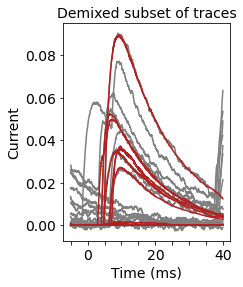

In [ ]:
plt.figure(figsize=(3, 4))
plt.plot(xs, psc[example_trials[:15]].T, color='gray')
plt.plot(xs, psc_dem[example_trials[:15]].T, color='firebrick')
plt.yticks(fontsize=fontsize)
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.ylabel('Current', fontsize=fontsize)
plt.title('Demixed subset of traces', fontsize=fontsize)
plt.xticks(xticks)
plt.gca().set_xticklabels(xticklabels, fontsize=fontsize)
plt.show()

In [ ]:
# Setup model with default priors
model = cm.Model(N)

"""
Optional: explicitly specify priors.

priors = {
  'alpha': 1/4 * np.ones(N),  # prior connection probability, used for CAVI-SnS only
  'phi': np.c_[1e-1 * np.ones(N), 5e0 * np.ones(N)],  # modes of power curve sigmoid coefficients
  'phi_cov': np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])),   # power curve prior covariances
  'mu': np.zeros(N),  # synaptic weight prior mean
  'beta': 1e1 * np.ones(N),   # synaptic weight prior standard deviation
  'shape': 1.,  # shape and rate parameters for gamma-distributed noise
  'rate': 1e-1
}

model = cm.Model(N, priors=priors)

"""

"\nOptional: explicitly specify priors.\n\npriors = {\n  'alpha': 1/4 * np.ones(N),  # prior connection probability, used for CAVI-SnS only\n  'phi': np.c_[1e-1 * np.ones(N), 5e0 * np.ones(N)],  # modes of power curve sigmoid coefficients\n  'phi_cov': np.array([np.array([[1e-1, 0], [0, 1e0]]) for _ in range(N)])),   # power curve prior covariances\n  'mu': np.zeros(N),  # synaptic weight prior mean\n  'beta': 1e1 * np.ones(N),   # synaptic weight prior standard deviation\n  'shape': 1.,  # shape and rate parameters for gamma-distributed noise\n  'rate': 1e-1\n}\n\nmodel = cm.Model(N, priors=priors)\n\n"

In [ ]:
# Specify fitting options
msrmp = 0.4 # minimum spike rate at maximum power
fit_options = {'iters': 50, 'save_histories': False, 'msrmp': msrmp} #'y_xcorr_thresh': 1e-3, 'tol': 0.05, 'penalty': 1,
method = 'caviar'

# Fit model
model.fit(psc_dem, stim_matrix, method=method, fit_options=fit_options)

Running coordinate-ascent variational inference and isotonic regularisation (CAVIaR) algorithm.


100%|██████████| 50/50 [00:25<00:00,  1.97it/s]


Examining 181/200 cells for false negatives...
Cell reconnection complete.


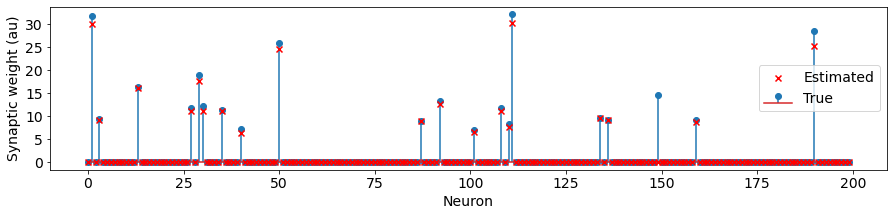


R2:  0.954633289354235


In [ ]:
plt.figure(figsize=(15, 3))
plt.stem(np.arange(N), sim['weights'], label='True')
plt.scatter(np.arange(N), model.state['mu'], marker='x', color='r', label='Estimated', zorder=N)
plt.legend(fontsize=fontsize)
plt.xlabel('Neuron', fontsize=fontsize)
plt.ylabel('Synaptic weight (au)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.show()

print('\nR2: ', r2_score(sim['weights'], model.state['mu']))

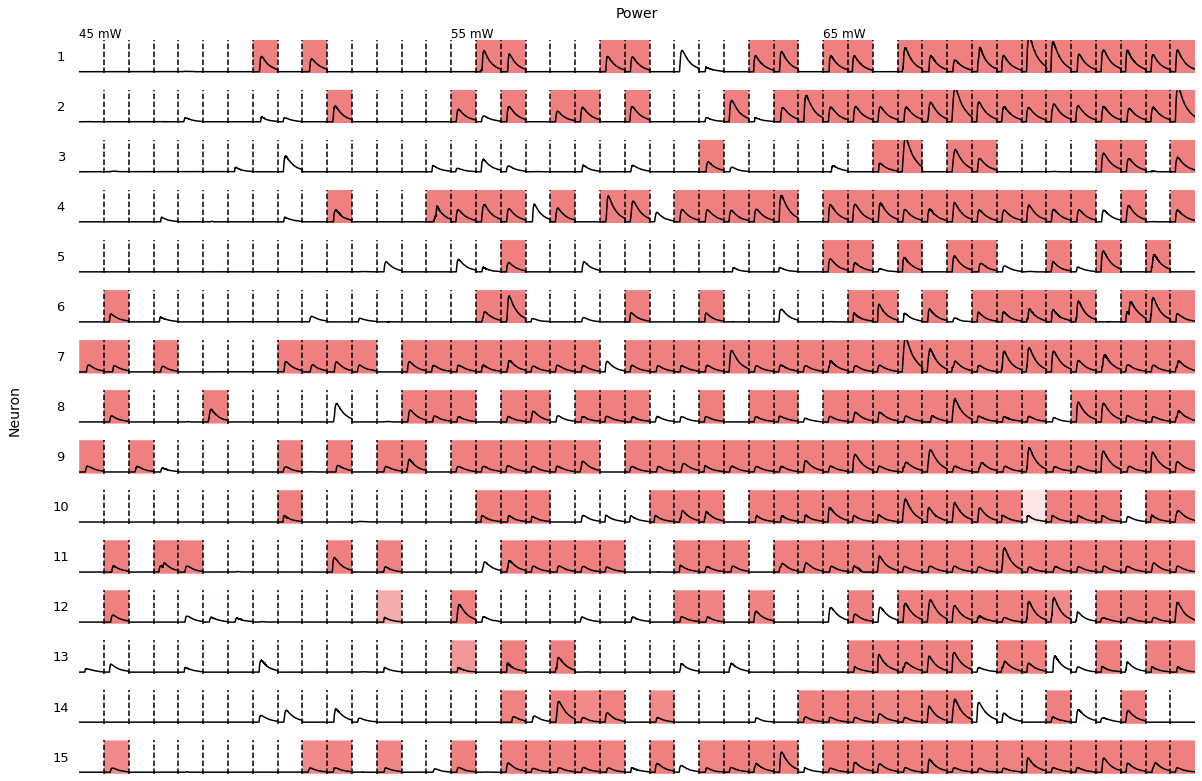

In [ ]:
"""

Visualise spike/connectivity inference via "checkerboard plot".

Cells shaded red indicate listed neuron elicited presynaptic spike on that 
trial. Opacity indicates uncertainty (faint shading represents low certainty, 
opaque shading represents high certainty).

Cells shaded blue indicate detected spontaneous PSC.

"""

plot_checkerboard(psc_dem, stim_matrix, model, fig_width=20, n_plots=15, max_trials_to_show=45, labels=np.arange(N), ylabelpad=0.075)